/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: Mean of empty slice
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: Mean of empty slice
/Us

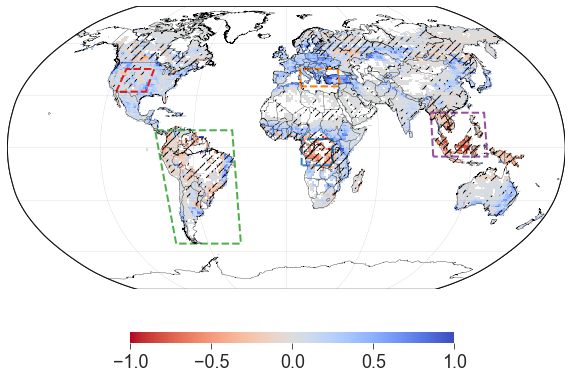

In [40]:
import numpy as np
import cartopy
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import BoundaryNorm
import sys
import pandas as pd
import matplotlib as mpl
from netCDF4 import Dataset
from matplotlib import cm
from mpl_toolkits.basemap import Basemap, cm
import math
import shapefile as shp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('seaborn-ticks')

title_size  = 20
marker_size = 7
stepsize    = 0.01
label_size  = 9
border_size = 0.4
tick_size   = 9
legend_size = 9
line_width  = 1.0
rotation=45
text_size=8
alpha       = 0.25
border_width = 0.0


### read data
data_dir="../data/"

#### plot
figure_width=10
figure_length=6
figure_rows = 1
figure_cols = 1
subplot_ratio=1

def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var]
    data=np.array(data)
    return data

def mask_data(data,missVal):
    data=np.where(data==missVal, np.nan,data)
    data=np.where(data>1e35, np.nan,data)
    return data

def fill_missingVal(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

def draw_screen_poly( lats, lons, m,color):
    from matplotlib.patches import Polygon
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( list(xy), facecolor='none', edgecolor=color,alpha=1.0,linewidth=2.0,linestyle="--")
    plt.gca().add_patch(poly)
    
def plotmap(data,ax,sigtest):
    lon_0 = np.mean(lons)
    lat_0 = np.mean(lats)
    m = Basemap(projection='robin',lon_0=lon_0,lat_0=lat_0,\
                llcrnrlat=np.amin(lats),urcrnrlat=np.amax(lats),\
                llcrnrlon=np.amin(lons),urcrnrlon=np.amax(lons),\
                rsphere=6371200.,resolution='l',area_thresh=10000,ax=ax)

    linewidth=0.3
    m.drawcoastlines(color='k', linewidth=linewidth)
    m.drawcountries(color='k', linewidth=linewidth)
    m.drawmapboundary(fill_color='white', zorder=-1)
    m.fillcontinents(color='0.8', lake_color='white', zorder=0)
    
    m.drawparallels(np.arange(-60.,91.,30.), dashes=[1,1], linewidth=0.25, color='0.5')
    m.drawmeridians(np.arange(0., 360., 60.), dashes=[1,1], linewidth=0.25, color='0.5')
    
    regions = ["Central US", "EU",\
               "SEA","Africa","South America"]
    beglats = [32,35,\
               -5,-10,-55]
    endlats = [45,45,\
               20,5,10]
    beglons = [-115,10,\
               95,10,-85]
    endlons = [-95,37,\
               130,30,-35]
    colors = ["#e41a1c","#ff7f00","#984ea3",\
              "#377eb8","#4daf4a"]
    for lat_var_b, lat_var_e, lon_var_b, lon_var_e,color in zip(beglats,endlats,beglons,endlons,colors):
        lats_rec = [lat_var_b,lat_var_e,lat_var_e,lat_var_b]
        lons_rec = [lon_var_b,lon_var_b,lon_var_e,lon_var_e]
        draw_screen_poly( lats_rec, lons_rec, m ,color)
    
    cmap = plt.get_cmap('coolwarm_r')
    cmap.set_under('white')
    cmap.set_bad('white')
        
    viridisBig = plt.get_cmap('jet', 16)
    newcmp = ListedColormap(viridisBig(np.linspace(0.2, 0.4, 8)))
    mcolors = plt.cm.YlOrRd(np.linspace(0.2, 0.5, 8))
    cmap_custom = ListedColormap(mcolors)

    plotdata = np.vstack([m.transform_scalar(data[:, :], lons, lats, glon, glat).reshape(glat, glon)])
    lon = np.arange(-180, 180, 1.25)
    lat = np.arange(-90, 90, 0.94)
    lon, lat = np.meshgrid(lon, lat)
    lon, lat = m(lon, lat)
       
    cs = m.pcolormesh(lon, lat, data,  vmin=vmin, vmax=vmax, cmap=cmap, \
                      rasterized=False, edgecolor='0.6', linewidth=0,alpha = 1.0)
    zm = np.ma.masked_greater(sigtest, 0.05)
    m.pcolor(lon, lat, zm, hatch='///', alpha=0.)
    ticks = np.arange(vmin,vmax+1,1)
    mpl.rcParams['axes.linewidth'] = border_width
    mpl.rcParams['axes.edgecolor'] = "white"
    return cs

def read_one_ensemble_sigtest(var,caseid,season):
    rcp="SSP226Lu-BIOCROP_"+caseid
    fname=data_dir +var+"_"+rcp+"_end_century_"+season+"_siglvl.nc"
    data = read_data(fname, "sigtest")
    data = fill_missingVal(data,1e36)
    data = roller(data)
    sigtest=fill_missingVal(data,1e36)
    return sigtest

def read_onedata(var,factor,caseid):
    fname=fname=data_dir +var+"_diff_"+caseid+"_end_century_meanAnnual.nc"
    data = read_data(fname, "diff")
    data = fill_missingVal(data,1e36)
    data = data*factor
    data=fill_missingVal(data,1e36)
    return data

def read_one_ensemble(var,caseid):
    factor = 1.0
    data1=read_onedata("NBP",factor,caseid)
    
    factor = 0.363 #median value of the range for the C_BECCS parameters
    data2=read_onedata("LIVESTEMC_TO_BIOFUELC",factor,caseid)
    data3=read_onedata("LEAFC_TO_BIOFUELC",factor,caseid)
    
    factor = 1.35# median value of the range for the C_offset parameters
    data4=read_onedata("BIOFUELPROD1C_LOSS",factor,caseid)
    
    data_final=data1+data2+data3+data4
    return data_final


### read data and call plot
def sub_function():
    fig, ax = plt.subplots(figure_rows, figure_cols, figsize=(figure_width,figure_length))
    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(var,caseid)
    data=np.nanmean(ensbase,axis=0)
    data[data==0]=np.nan
    plotdata=data
    
    ### significant test
    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble_sigtest("NBP",caseid,season)
    sigtest = np.nanmean(ensbase,axis=0)
    
    cs = plotmap(plotdata,ax,sigtest)
    ticks = np.arange(vmin,vmax+step,step)
    cbaxes = fig.add_axes([0.296, 0.05, 0.45, 0.027]) # X,Y position,length, wideth,
    cbar = fig.colorbar(cs, cax=cbaxes, ticks=ticks, orientation='horizontal', extend='neither', \
                 spacing='proportional')
    cbar.ax.tick_params(labelsize=18)
    
    fig_dir = "../figures/"
    fname=fig_dir+"Fig2d.pdf"
#     fig.savefig(fname,format='pdf',bbox_inches='tight')
    return data


missVal=1e36
vmax =1
vmin=(-1)*vmax
step=.5 
var = "Cnet"
ens_size=3
data = sub_function()
